# Exercise 6: Banana Quality Classification Analysis

## Dataset Overview

For this classification exercise, I have chosen the **Banana Quality Dataset** which contains measurements of various physical and chemical properties of bananas to predict their quality classification.

**Dataset source:** https://www.kaggle.com/datasets/l3llff/banana

### Problem Statement

We aim to predict the quality classification of bananas, which is labeled as either Good or Bad. This classification is based on various physical and chemical measurements of the bananas, such as Size, Weight, Sweetness, Softness, HarvestTime, Ripeness, and Acidity. 

Solving this problem is valuable for industries like agriculture, food safety, and supply chain optimization, as it can improve sorting, pricing, and waste reduction processes.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Data analysis

Here we can see that the dataset contains a lot of information about a banana:

- **Size**: Normalized measurement of banana size
- **Weight**: Normalized weight of the banana
- **Sweetness**: Sweetness level measurement (likely from chemical analysis)
- **Softness**: Texture measurement indicating ripeness/firmness
- **HarvestTime**: Timing of harvest (normalized)
- **Ripeness**: Ripeness score of the banana
- **Acidity**: Acidity level measurement

The target variable is **Quality** with two classes:
- **Good**: High quality bananas suitable for consumption/sale
- **Bad**: Poor quality bananas that should be discarded


There is also 8000 entries

In [2]:
data_path = '../data/banana/banana_quality.csv'
df = pd.read_csv(data_path)

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (8000, 8)

First 5 rows:
       Size    Weight  Sweetness  Softness  HarvestTime  Ripeness   Acidity  \
0 -1.924968  0.468078   3.077832 -1.472177     0.294799  2.435570  0.271290   
1 -2.409751  0.486870   0.346921 -2.495099    -0.892213  2.067549  0.307325   
2 -0.357607  1.483176   1.568452 -2.645145    -0.647267  3.090643  1.427322   
3 -0.868524  1.566201   1.889605 -1.273761    -1.006278  1.873001  0.477862   
4  0.651825  1.319199  -0.022459 -1.209709    -1.430692  1.078345  2.812442   

  Quality  
0    Good  
1    Good  
2    Good  
3    Good  
4    Good  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         8000 non-null   float64
 1   Weight       8000 non-null   float64
 2   Sweetness    8000 non-null   float64
 3   Softness     8000 non-null   float64
 4   HarvestTime  8000 non-null   float6

# Class distribution

For the class distribution we can see that there is about half good and half bad bananas.

Class Distribution:
Quality
Good    4006
Bad     3994
Name: count, dtype: int64

Class proportions:
Quality
Good    0.50075
Bad     0.49925
Name: proportion, dtype: float64


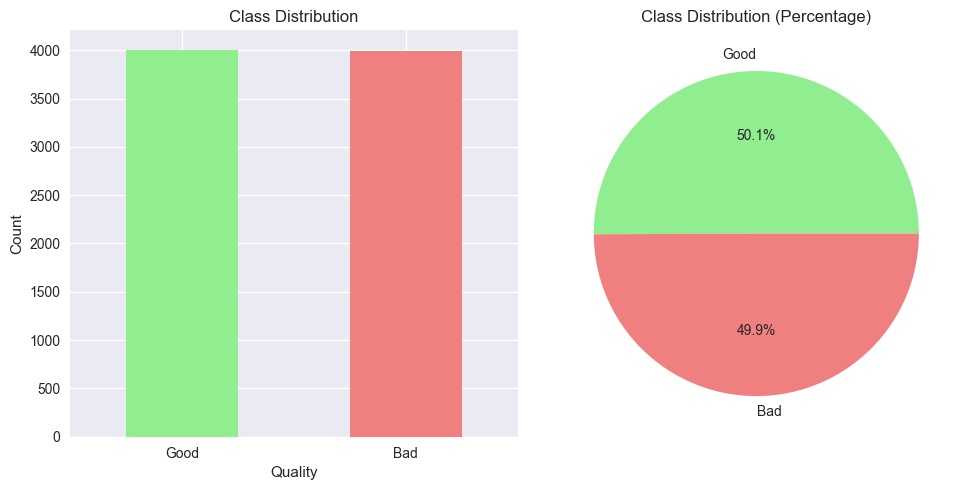

In [3]:
# Analyze class distribution
print("Class Distribution:")
class_counts = df['Quality'].value_counts()
print(class_counts)
print(f"\nClass proportions:")
print(df['Quality'].value_counts(normalize=True))

# Visualize class distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df['Quality'].value_counts().plot(kind='bar', color=['lightgreen', 'lightcoral'])
plt.title('Class Distribution')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', 
        colors=['lightgreen', 'lightcoral'])
plt.title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

We can see that for most features, the distributions of Good and Bad bananas overlap a lot, indicating that the features may not strongly differentiate between the two classes. But, subtle shifts in the peaks of the distributions suggest that some features might still contribute to classification.

By analyzing each graph we can see that:
   - Size: Good bananas tend to have slightly larger sizes compared to Bad bananas.
   - Weight: Similar to Size, Good bananas appear to have higher weights.
   - Sweetness: Good bananas show a higher sweetness level, with a noticeable shift in the peak.
   - Softness: Good bananas are softer, which aligns with ripeness being a factor for quality.
   - HarvestTime: The distributions are similar, suggesting this feature may have limited predictive power.
   - Ripeness: Good bananas are generally riper, as expected.
   - Acidity: Bad bananas show slightly higher acidity levels.

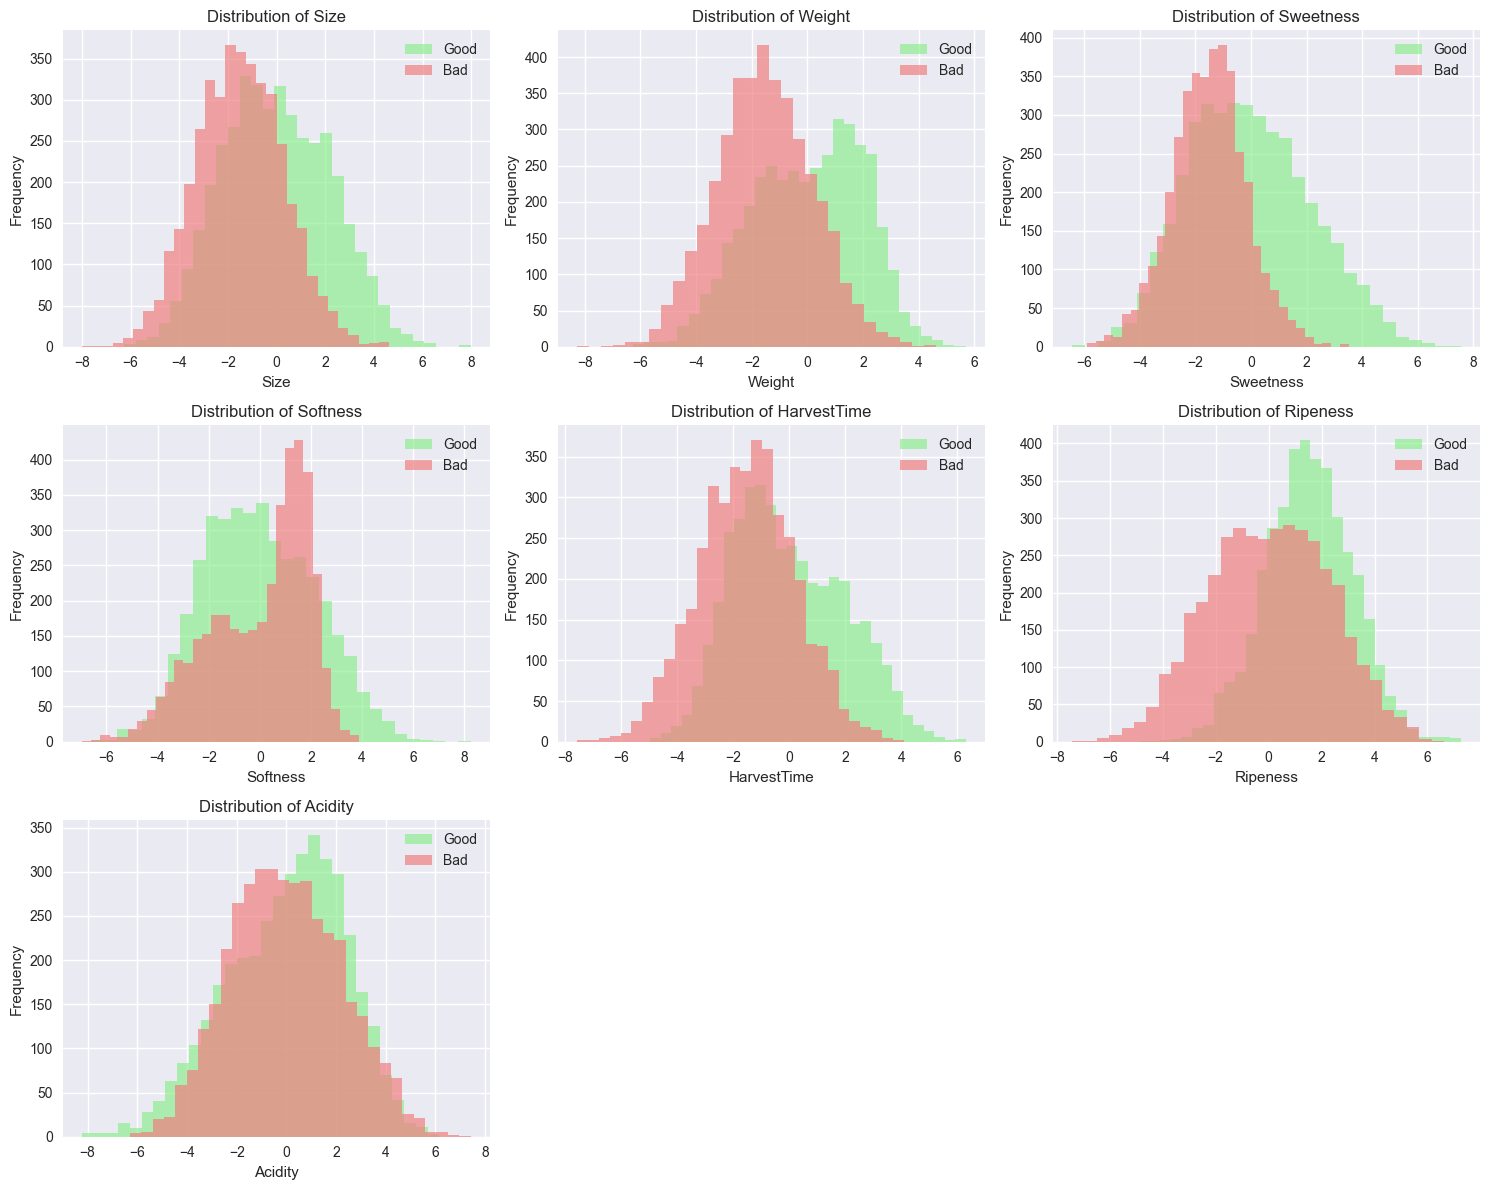

In [4]:
features = ['Size', 'Weight', 'Sweetness', 'Softness', 'HarvestTime', 'Ripeness', 'Acidity']

plt.figure(figsize=(15, 12))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i+1)
    
    df[df['Quality'] == 'Good'][feature].hist(alpha=0.7, label='Good', bins=30, color='lightgreen')
    df[df['Quality'] == 'Bad'][feature].hist(alpha=0.7, label='Bad', bins=30, color='lightcoral')
    
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

# Correlation matrix:

The matrix shows that while some features are moderately correlated (like `Size` or `HarvestTime`), most features are mostly independent.

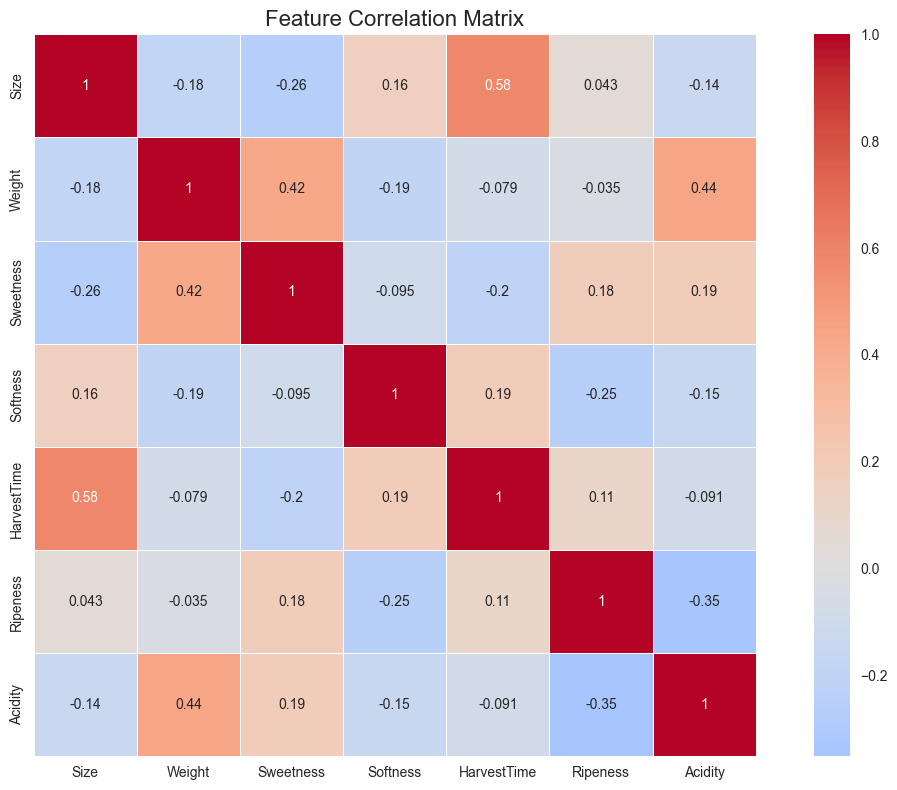

In [5]:
plt.figure(figsize=(12, 8))

correlation_matrix = df[features].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()


## Data Preprocessing

Based on our exploratory analysis, we can see that:
- The data is well balanced (50/50)
- The values seems standardized around 0

We don't need to do major preprocessing, we just need to split the data in train/test data and to Convert 'Good'/'Bad' to numeric values

In [6]:
X = df[features].copy()
y = df['Quality'].copy()

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"Label encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

Label encoding: {'Bad': np.int64(0), 'Good': np.int64(1)}


# Training:

## Cross validation:

We train six machine learning models (Logistic Regression, Random Forest, Gradient Boosting, SVM, K-Nearest Neighbors, and Naive Bayes) using 5-fold cross-validation to evaluate their performance. It calculates mean accuracy and standard deviation for each model across folds. After cross-validation, the models are trained on the training set.

We also observe that:

- SVM and KNN achieved the highest accuracy and stability, making them the best candidates.
- Random Forest and Gradient Boosting also performed well.
- Logistic Regression and Naive Bayes provide reasonable accuracy but are outperformed by more complex models.

In [7]:

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

cv_results = {}
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='accuracy')
    cv_results[name] = cv_scores
    
    print(f"{name}:")
    print(f"  Mean Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  Individual folds: {[f'{score:.4f}' for score in cv_scores]}")
    print()

trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model

print("Models trained successfully!")

Logistic Regression:
  Mean Accuracy: 0.8773 (+/- 0.0231)
  Individual folds: ['0.8641', '0.8914', '0.8891', '0.8773', '0.8648']

Random Forest:
  Mean Accuracy: 0.9711 (+/- 0.0043)
  Individual folds: ['0.9719', '0.9742', '0.9695', '0.9719', '0.9680']

Gradient Boosting:
  Mean Accuracy: 0.9572 (+/- 0.0158)
  Individual folds: ['0.9508', '0.9625', '0.9586', '0.9680', '0.9461']

SVM:
  Mean Accuracy: 0.9803 (+/- 0.0052)
  Individual folds: ['0.9789', '0.9828', '0.9797', '0.9836', '0.9766']

K-Nearest Neighbors:
  Mean Accuracy: 0.9781 (+/- 0.0056)
  Individual folds: ['0.9773', '0.9828', '0.9773', '0.9789', '0.9742']

Naive Bayes:
  Mean Accuracy: 0.8869 (+/- 0.0217)
  Individual folds: ['0.8797', '0.8930', '0.8922', '0.9000', '0.8695']

Models trained successfully!


## Evaluation on test set:


We now evaluate on the test set to ensure the model generalizes well.
Overall, SVM stands out as the most suitable model for to classify bananas, with KNN and Random Forest also as strong alternatives. Gradient Boosting offers reliable performance, while Naive Bayes and Logistic Regression are better suited for simpler problems or as baseline models.

In [8]:
test_results = {}

for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] 
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    test_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"{name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    print()

comparison_df = pd.DataFrame({
    'Model': list(test_results.keys()),
    'Accuracy': [results['accuracy'] for results in test_results.values()],
    'Precision': [results['precision'] for results in test_results.values()],
    'Recall': [results['recall'] for results in test_results.values()],
    'F1-Score': [results['f1'] for results in test_results.values()],
    'ROC-AUC': [results['roc_auc'] for results in test_results.values()]
}).round(4)

comparison_df = comparison_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)
print("Model Performance Summary (sorted by F1-Score):")
print(comparison_df.to_string(index=False))

Logistic Regression:
  Accuracy:  0.8719
  Precision: 0.8556
  Recall:    0.8951
  F1-Score:  0.8749
  ROC-AUC:   0.9444

Random Forest:
  Accuracy:  0.9663
  Precision: 0.9663
  Recall:    0.9663
  F1-Score:  0.9663
  ROC-AUC:   0.9920

Gradient Boosting:
  Accuracy:  0.9456
  Precision: 0.9474
  Recall:    0.9438
  F1-Score:  0.9456
  ROC-AUC:   0.9868

SVM:
  Accuracy:  0.9819
  Precision: 0.9886
  Recall:    0.9750
  F1-Score:  0.9818
  ROC-AUC:   0.9932

K-Nearest Neighbors:
  Accuracy:  0.9781
  Precision: 0.9836
  Recall:    0.9725
  F1-Score:  0.9780
  ROC-AUC:   0.9919

Naive Bayes:
  Accuracy:  0.8856
  Precision: 0.8627
  Recall:    0.9176
  F1-Score:  0.8893
  ROC-AUC:   0.9514

Model Performance Summary (sorted by F1-Score):
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
                SVM    0.9819     0.9886  0.9750    0.9818   0.9932
K-Nearest Neighbors    0.9781     0.9836  0.9725    0.9780   0.9919
      Random Forest    0.9662     0.9663  0.9663

# Conclusion

The results obtained demonstrate that the problem of predicting banana quality classification (Good or Bad) has been effectively addressed using machine learning models. The evaluation metrics, including accuracy, precision, recall, F1-Score, and ROC-AUC, indicate strong performance across multiple models.

SVM achieved the highest performance, with an accuracy of 98.19%, F1-Score of 0.9818, and ROC-AUC of 0.9932. This indicates that SVM is highly effective at distinguishing between the two classes and generalizes well to unseen data.

So yes, we can say that the problem has been solved effectively, but the dataset is really user friendly (balanced and already standardized) which makes the problem much simpler. Real world datasets may have more problems, so more optimizations should be added when having a more imbalanced dataset. I did not have to change any hyperparameters to get very good results, but we may get better results with hyperparameters tuning when having a more imbalanced dataset.